# Notebook for testing the MCMF file 

Todo:
* Mask the MCMF with the DES dataframe. 

Bug fixes:
* The best candidate and properties are determined by f_cont not in ascending order by Z1, Z2, Z3. 


In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
import numpy as np
import healpy as hp
import struct

import setup
from astropy.table import Table
#Coordinate
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.cosmology import WMAP9 as cosmo
from astropy.coordinates import SkyCoord
from astropy.io import fits

import pandas as pd
from tqdm import tqdm
import math

In [73]:
#Plotting params
#Plotting parameters
import matplotlib as mpl

mpl.rcParams['xtick.direction'], mpl.rcParams['ytick.direction'] = 'in', 'in'
mpl.rcParams['xtick.major.size'], mpl.rcParams['xtick.minor.size'] = 14, 8
mpl.rcParams['xtick.major.width'], mpl.rcParams['xtick.minor.width'] = 1.2, 0.8
mpl.rcParams['xtick.major.pad'], mpl.rcParams['xtick.minor.pad'] = 10, 10
mpl.rcParams['ytick.major.size'], mpl.rcParams['ytick.minor.size'] = 14, 8
mpl.rcParams['ytick.major.width'], mpl.rcParams['ytick.minor.width'] = 1.2, 0.8
mpl.rcParams['xtick.labelsize'], mpl.rcParams['ytick.labelsize'] = 20, 20

# Parameters used in this module
# One dictionary to store default values
# Another that user can view/change as necessary
Default_Params = {'default_cmap'   : plt.cm.coolwarm,
                  'title_fontsize' : 25,
                  'legend_fontsize': 22,
                  'xlabel_fontsize': 30,
                  'ylabel_fontsize': 30,
                  'scatter_factor' : 1.0}

Params = Default_Params.copy()

In [74]:
import warnings
warnings.filterwarnings('ignore')

In [105]:
from matched_clusters import matched_clusters
from matched_clusters_plot import *

### Reading the data files. 

### Import SPT, MCMF files to combine. Skip if importing existing matched catalog 

In [76]:
##Created a combined dataframe of SPT matched DES clusters in the DES Y3 footprint. 
datadir = setup.data_home_dir()

#SPT
spt_all = datadir + 'spt_catalogs/SPT-SZ_SN4_MCMF_6Jul2021.csv'

#DES--redMaPPer full run vl50
redM_full = datadir + 'redMaPPer/y3_gold_2.2.1_wide_sofcol_run2_redmapper_v6.4.22+2_lgt5_vl50_catalog.csv'
#spt_data = Table.read(spt_all, format='fits')
#dat.convert_bytestring_to_unicode() #Converts bytes to string for string columns e.g. SPT ID and Field name for correct syntax

#spt_data = dat.to_pandas()
redM_data = pd.read_csv(redM_full)
spt_data = pd.read_csv(spt_all)

print(redM_data.columns)
print(spt_data.columns)

Index(['MEM_MATCH_ID', 'RA', 'DEC', 'MODEL_MAG', 'MODEL_MAGERR', 'REFMAG',
       'REFMAG_ERR', 'ZRED', 'ZRED_E', 'ZRED_CHISQ', 'BCG_SPEC_Z',
       'Z_SPEC_INIT', 'Z_INIT', 'Z', 'LAMBDA_CHISQ', 'LAMBDA_CHISQ_E',
       'LAMBDA_ZRED', 'LAMBDA_ZRED_E', 'R_LAMBDA', 'SCALEVAL', 'MASKFRAC',
       'GEOMASKFRAC', 'C_LAMBDA', 'C_LAMBDA_ERR', 'MAG_LAMBDA_ERR', 'CHISQ',
       'Z_LAMBDA', 'Z_LAMBDA_E', 'Z_LAMBDA_NITER', 'EBV_MEAN', 'LNLAMLIKE',
       'LNBCGLIKE', 'LNLIKE', 'PZBINS', 'PZ', 'NCROSS', 'RMASK', 'RA_ORIG',
       'DEC_ORIG', 'W', 'DLAMBDA_DZ', 'DLAMBDA_DZ2', 'DLAMBDAVAR_DZ',
       'DLAMBDAVAR_DZ2', 'LAMBDA_CHISQ_C', 'LAMBDA_CHISQ_CE', 'NCENT',
       'NCENT_GOOD', 'RA_CENT', 'DEC_CENT', 'ID_CENT', 'LAMBDA_CHISQ_CENT',
       'ZLAMBDA_CENT', 'P_BCG', 'P_CEN', 'Q_CEN', 'P_FG', 'Q_MISS', 'P_SAT',
       'P_C', 'BCG_ILUM', 'ILUM', 'Z_LAMBDA_RAW', 'Z_LAMBDA_E_RAW',
       'LIM_EXPTIME', 'LIM_LIMMAG_DERED', 'LIM_LIMMAG', 'LIM_LIMMAG_HARD',
       'MASKGAL_INDEX'],
      dtype='object')

In [77]:
spt_data.shape

(1513, 56)

In [78]:
spt_data.describe()

,XPEAK,YPEAK,PEAKVAL,PEAKSIG,WHFILT,NPIXELSX,NPIXELSY,DEPTH,RA,DEC,...,MSTAR_HZ1_LFC,MSTAR_HZ2_LFC,Z_COMB,F_CONT_COMB,LAMBDA_COMB,DES_OR_HZ,RA_COMB,DEC_COMB,M500_COMB,F_CONT_COMB_UC
count,1513.000000,1513.000000,1513.000000,1513.000000,1513.000000,1513.000000,1513.000000,1513.0,1513.000000,1513.000000,...,1270.000000,1262.000000,1513.000000,1513.000000,1513.000000,1513.000000,1513.000000,1513.000000,1.513000e+03,1513.000000
mean,2558.033462,1382.305366,0.000238,5.216942,2.359551,5051.658956,2856.549901,1.0,151.123525,-51.464542,...,10.505698,10.499009,-4.486176,8.348436,31.131280,0.076669,92.661264,-32.133477,2.003752e+14,8.347575
std,1474.195931,715.922640,0.000156,2.685548,2.995191,1515.299911,539.018306,0.0,135.125428,7.111956,...,4.066843,4.079548,21.953831,27.077867,47.486149,0.314031,131.033827,25.252747,8.887583e+13,27.078113
min,257.000000,250.500183,0.000081,4.002506,0.000000,2700.000000,1800.000000,1.0,0.060944,-65.310770,...,0.000000,0.000000,-99.900002,0.000000,-99.900002,0.000000,-1.000000,-65.315101,0.000000e+00,0.000000
25%,1423.069702,773.743042,0.000118,4.166766,0.000000,4000.000000,3000.000000,1.0,41.866776,-57.385723,...,11.449849,11.435184,0.312480,0.001536,4.891298,0.000000,-1.000000,-53.711248,1.819695e+14,0.001479
50%,2333.008545,1282.907959,0.000193,4.424314,1.000000,4700.000000,3000.000000,1.0,81.115610,-50.920853,...,12.087566,12.085408,0.542860,0.119826,22.653160,0.000000,31.284715,-44.484871,1.975773e+14,0.113802
75%,3497.008057,1930.712891,0.000324,5.109866,4.000000,5900.000000,3000.000000,1.0,318.264100,-45.243760,...,12.426087,12.432181,0.795140,0.712328,58.872053,0.000000,88.168545,-1.000000,2.172316e+14,0.711307
max,8348.110352,3037.690674,0.002056,42.356873,11.000000,8700.000000,3600.000000,1.0,359.959300,-39.845375,...,13.142663,13.304514,2.035000,99.900000,242.525440,2.000000,359.927314,-1.000000,1.026668e+15,99.900000


## Matching the catalogs -- skip this if using the saved file

* RA, DEC of cluster
* Richness distribution
* Redshift distribution. 
* Number of clusters with f_cont. 
* Xi properties of clusters. 
* richness distribution of the clusters
* Apply z_lfc > 0 for DES candidates and match with redMaPPer. 


#### Spatial Properties of the SPT Clusters. 

In [79]:
#For clusters using the (grizY) DES band for photo-z calibration
spt_data_zlfc = spt_data[spt_data['Z_LFC'] > 0]

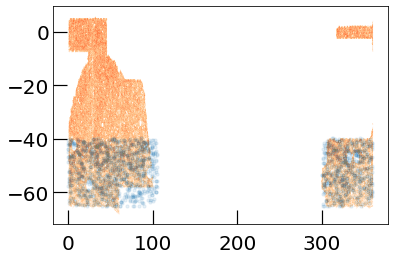

In [80]:
plt.scatter(spt_data['RA'], spt_data['DEC'], alpha=0.1, s=10)
plt.scatter(redM_data['RA'], redM_data['DEC'], alpha=0.01, s = 0.1)
plt.show()

#### Masking with the DES footprint

In [81]:
#DES footprint
y3_footprint = datadir + 'redMaPPer/y3a2_griz_o.4096_t.32768_coverfoot_EQU.fits.gz' 

In [82]:
des_mask = hp.read_map(y3_footprint)
#des_footprint[1].data

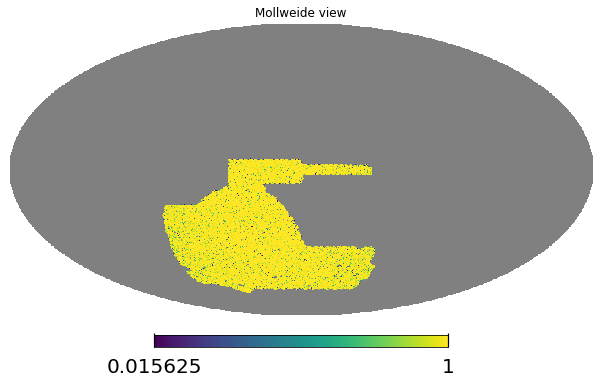

In [83]:
hp.mollview(des_mask)

In [84]:
spt_pix=hp.ang2pix(4096, spt_data['RA'].values, spt_data['DEC'].values, lonlat=True)
spt_loc = des_mask[spt_pix] > 0.5 #Use 0.5 for a more conservative cut. 
spt_data = spt_data[spt_loc]

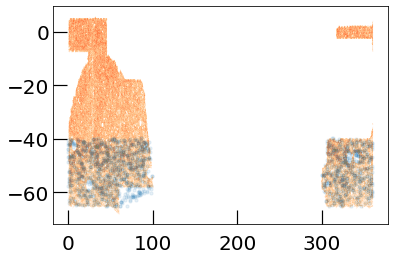

In [85]:
plt.scatter(spt_data['RA'], spt_data['DEC'], alpha=0.1, s=10)
plt.scatter(redM_data['RA'], redM_data['DEC'], alpha=0.01, s = 0.1)
plt.show()

In [86]:
print("Number of SPT clusters after footprint mask is", len(spt_data))

Number of SPT clusters after footprint mask is 1357


### Scaling relations of the clusters. 

In [87]:
xi = spt_data['PEAKSIG']; lambda_chisq = spt_data['LAMBDA_LFC']; z=spt_data['Z_LFC']; m500 = spt_data['M500_COMB'] 

In [88]:
    def plot_scaling_relations(xi, lambda_chisq, z, m500, maskfrac=True, verbose=True):

        #Need to change this. Make this work. 
        fig, axs = plt.subplots(1, 3, tight_layout=True, figsize=(12,5))
        [a.grid(True) for a in axs]

        axs[0].scatter(xi, lambda_chisq)
        axs[1].scatter(lambda_chisq, m500)
        sc = axs[2].scatter(z, xi)

        #labels
        axs[0].set_xlabel(r'$PEAKSIG$', fontsize=16); axs[0].set_ylabel(r'$\lambda$', fontsize=16)
        axs[1].set_xlabel(r'$\lambda$', fontsize=16); axs[1].set_ylabel(r'$M_{500}$', fontsize=16)
        axs[2].set_xlabel(r'$Z_{\lambda}$', fontsize=16); axs[2].set_ylabel(r'$PEAKSIG$', fontsize=16)
        
        
        axs[0].set_ylim([0,250])
        axs[2].set_xlim([0,2])

        plt.plot()
        return 

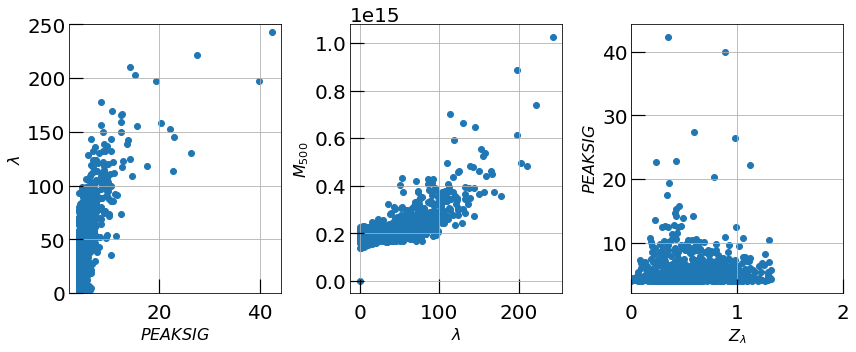

In [89]:
plot_scaling_relations(xi, lambda_chisq, z, m500)

## Applying filters. 
* Z_LFC > 0
* lambda > 20
* z > 0
* Xi > 4.25

In [90]:
##Applying filters. 
mask = spt_data['Z_LFC'] > 0
mask &= spt_data['LAMBDA_COMB'] > 20
mask &= spt_data['Z_COMB'] > 0
mask &= spt_data['PEAKSIG'] > 4
#mask &= spt_data['F_CONT_COMB'] < 0.3

In [91]:
spt_data_mask = spt_data[mask]
spt_data_mask.shape

(717, 56)

In [92]:
xi = spt_data_mask['PEAKVAL']; lambda_chisq = spt_data_mask['LAMBDA_LFC']; z=spt_data_mask['Z_LFC']; m500 = spt_data_mask['M500_COMB'] 

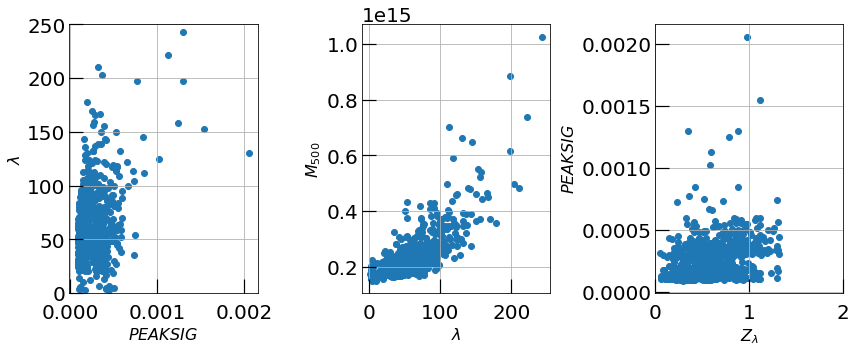

In [93]:
plot_scaling_relations(xi, lambda_chisq, z, m500)

In [94]:
## Fraction of objects with increasing contamination rate. 
f_cont_lim = np.linspace(0,1,200)
dist_fcont = {'f_cont_lim':f_cont_lim, 'num_fcont':f_cont_lim}

num_count = np.zeros(200)
for i, f_cont in enumerate(f_cont_lim):
    num_fcont_cur = len(spt_data[spt_data['F_CONT_COMB'] < f_cont])
    num_count[i] = num_fcont_cur
dist_fcont['num_fcont'] = num_count

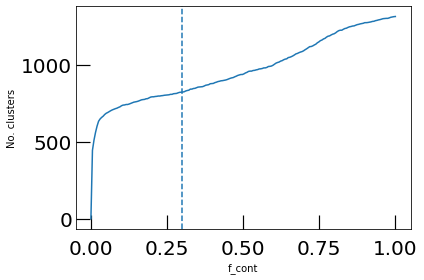

In [117]:
#Make this plot prettier.
plt.figure(tight_layout=True)
plt.plot(dist_fcont['f_cont_lim'], dist_fcont['num_fcont'])
plt.axvline(0.3, linestyle='dashed')
plt.xlabel('f_cont')
plt.ylabel('No. clusters')
#plt.savefig('mcmcf_sz_fcont_numclusters.png')
plt.show()

### Running the matching package

In [97]:
spt_data_match = spt_data.copy()
redM_data_match = redM_data.copy()

In [98]:
#Change the names of the dataframes
##Renaming some of the SPT and RedmaPPer column names to avoid using the same name. 
spt_data_match.rename(columns = {"PEAKSIG":"XI","RA":"RA_SPT", "DEC":"DEC_SPT", "Z_LFC":"Z_SPT", "M500_LFC":"M500",}, inplace=True)
print(spt_data_match.columns)

redM_data_match.rename(columns = {"RA":"RA_REDM", "DEC":"DEC_REDM", "Z":"Z_REDM"}, inplace=True)
print(redM_data_match.columns)

Index(['XPEAK', 'YPEAK', 'PEAKVAL', 'XI', 'WHFILT', 'SIG_V_FILT', 'NPIXELSX',
       'NPIXELSY', 'FIELD', 'DEPTH', 'RA_SPT', 'DEC_SPT', 'SCALE_FACTOR',
       'SPT_ID', 'Z_BOCQ', 'EZ_BOCQ', 'SPEC', 'Z_P1', 'Z_P2', 'Z_P3',
       'LAMBDA_P1', 'LAMBDA_P2', 'LAMBDA_P3', 'F_CONT_P1', 'F_CONT_P2',
       'F_CONT_P3', 'M500_P1', 'M500_P2', 'M500_P3', 'M500_HZ1_P1',
       'M500_HZ1_P2', 'M500_HZ2_P1', 'M500_HZ2_P2', 'M500_HZ1_LFC',
       'M500_HZ2_LFC', 'F_CONT_LFC', 'Z_SPT', 'LAMBDA_LFC', 'M500',
       'D_NEXTFCONT', 'F_CONT_HZ1_LFC', 'F_CONT_HZ2_LFC', 'Z_HZ1_LFC',
       'Z_HZ2_LFC', 'LAMBDA_HZ1_LFC', 'LAMBDA_HZ2_LFC', 'MSTAR_HZ1_LFC',
       'MSTAR_HZ2_LFC', 'Z_COMB', 'F_CONT_COMB', 'LAMBDA_COMB', 'DES_OR_HZ',
       'RA_COMB', 'DEC_COMB', 'M500_COMB', 'F_CONT_COMB_UC'],
      dtype='object')
Index(['MEM_MATCH_ID', 'RA_REDM', 'DEC_REDM', 'MODEL_MAG', 'MODEL_MAGERR',
       'REFMAG', 'REFMAG_ERR', 'ZRED', 'ZRED_E', 'ZRED_CHISQ', 'BCG_SPEC_Z',
       'Z_SPEC_INIT', 'Z_INIT', 'Z_REDM', 'LA

In [99]:
##Testing
matched_cl = matched_clusters(spt_data_match, redM_data_match, [0,2], verbose=False)
matched_cl.run_match(['RA_SPT','DEC_SPT','XI','Z_SPT'], ['RA_REDM','DEC_REDM','LAMBDA_CHISQ', 'Z_REDM'], \
                       1500, delta_z_lim = 0.1, aperture_type = 'distance', verbose=True)

Before z_cut number of SPT clusters is  1357
Before z cut number of RM clusters is  869335
After z cut number of SPT clusters is  1356
After z cut number of RM clusters is  869335


100%|██████████| 1356/1356 [04:04<00:00,  5.54it/s]


## Extracting the DataFrames

In [103]:
match_candidates_df = matched_cl.get_match_candidates_df()
match_top_df = matched_cl.get_match_top_df()
nomatch_df = matched_cl.get_nomatch_df()
num_match = matched_cl.get_num_match()
multiple_df = matched_cl.get_multiple_candidates()
print("Number of matches is {}".format(num_match))
print("Number of multiple candidates is {}".format(multiple_df['num_multiple']))

Number of matches is 798
Number of multiple candidates is 162


In [101]:
##Convert mass scale
match_top_df['M500'] = match_top_df['M500']/1e14

### Saving the matched cluster class Object

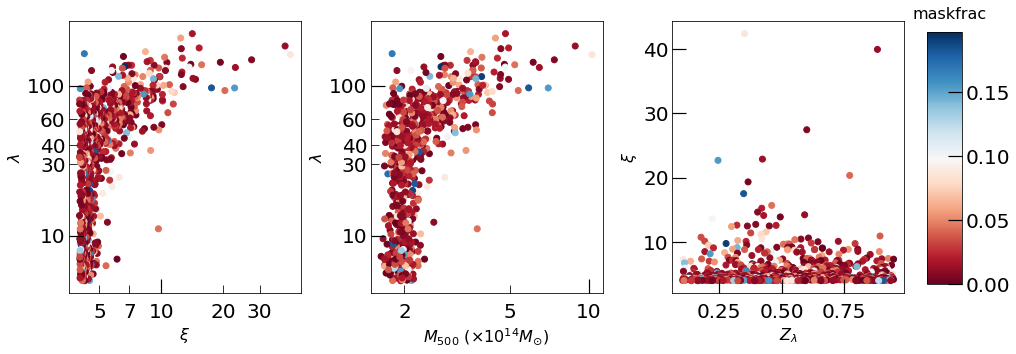

In [106]:
plot_scaling_relations(match_top_df)

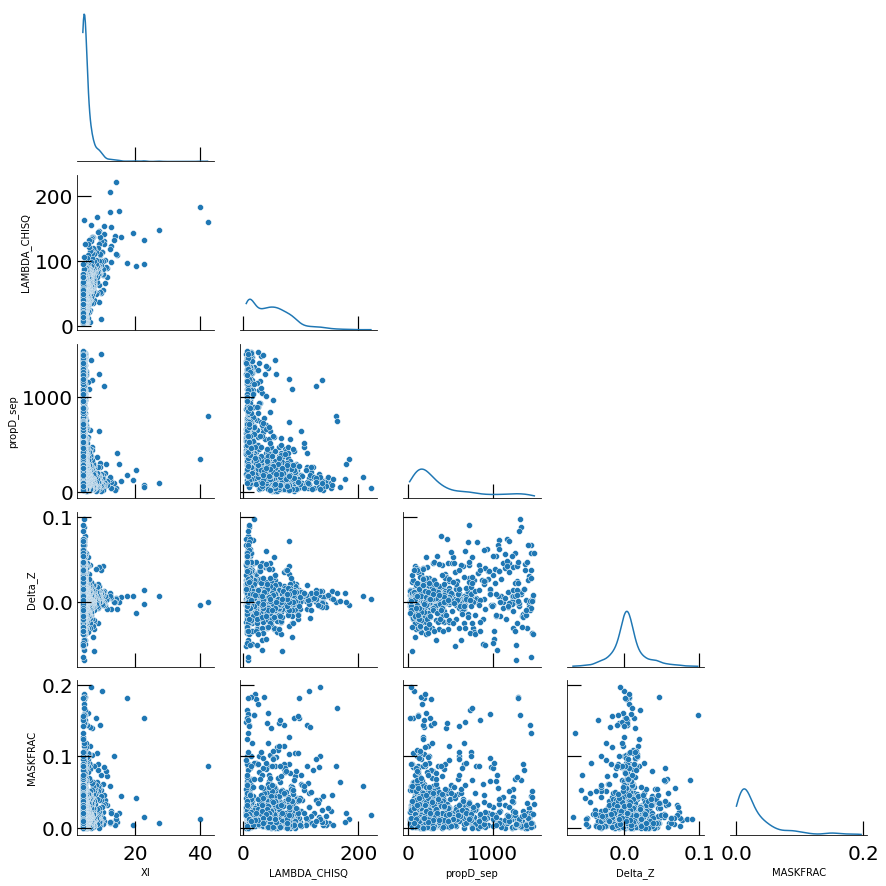

In [107]:
plot_matched_properties(match_top_df)

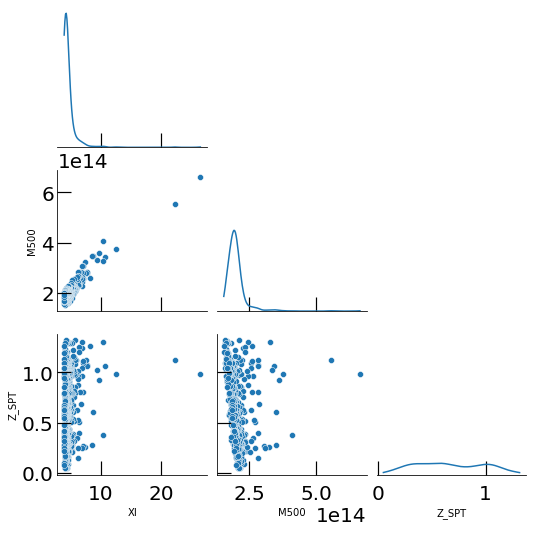

In [108]:
plot_nomatch_properties(nomatch_df)

### Testing for outliers

In [109]:
match_candidates_df.columns

Index(['XPEAK', 'YPEAK', 'PEAKVAL', 'XI', 'WHFILT', 'SIG_V_FILT', 'NPIXELSX',
       'NPIXELSY', 'FIELD', 'DEPTH', 'RA_SPT', 'DEC_SPT', 'SCALE_FACTOR',
       'SPT_ID', 'Z_BOCQ', 'EZ_BOCQ', 'SPEC', 'Z_P1', 'Z_P2', 'Z_P3',
       'LAMBDA_P1', 'LAMBDA_P2', 'LAMBDA_P3', 'F_CONT_P1', 'F_CONT_P2',
       'F_CONT_P3', 'M500_P1', 'M500_P2', 'M500_P3', 'M500_HZ1_P1',
       'M500_HZ1_P2', 'M500_HZ2_P1', 'M500_HZ2_P2', 'M500_HZ1_LFC',
       'M500_HZ2_LFC', 'F_CONT_LFC', 'Z_SPT', 'LAMBDA_LFC', 'M500',
       'D_NEXTFCONT', 'F_CONT_HZ1_LFC', 'F_CONT_HZ2_LFC', 'Z_HZ1_LFC',
       'Z_HZ2_LFC', 'LAMBDA_HZ1_LFC', 'LAMBDA_HZ2_LFC', 'MSTAR_HZ1_LFC',
       'MSTAR_HZ2_LFC', 'Z_COMB', 'F_CONT_COMB', 'LAMBDA_COMB', 'DES_OR_HZ',
       'RA_COMB', 'DEC_COMB', 'M500_COMB', 'F_CONT_COMB_UC', 'MEM_MATCH_ID',
       'propD_sep', 'Delta_Z', 'LAMBDA_CHISQ', 'MASKFRAC'],
      dtype='object')

In [110]:
mask =  (match_top_df.LAMBDA_CHISQ > 5) 
mask =  (match_top_df.LAMBDA_CHISQ < 6) 
mask &= (match_top_df.LAMBDA_LFC > 10)
match_top_df[mask][['SPT_ID', 'RA_SPT', 'DEC_SPT', 'LAMBDA_CHISQ', 'LAMBDA_LFC', 'MASKFRAC', 'Z_SPT']]

,SPT_ID,RA_SPT,DEC_SPT,LAMBDA_CHISQ,LAMBDA_LFC,MASKFRAC,Z_SPT
690,SPT-CLJ0159-4439,29.975750,-44.664597,5.023100,15.720580,0.148169,0.239042
1177,SPT-CLJ0555-5322,88.871700,-53.374596,5.785849,11.155215,0.154351,0.222030
1240,SPT-CLJ2025-4139,306.248660,-41.652782,5.084120,27.700627,0.054674,0.496838
1243,SPT-CLJ2050-6454,312.605070,-64.907974,5.023100,13.312448,0.042449,0.631123
1389,SPT-CLJ2204-4503,331.089660,-45.064583,5.465494,28.323038,0.001983,0.857460
1426,SPT-CLJ0259-4237,44.875095,-42.625010,5.572279,10.889929,0.005463,0.187420
1483,SPT-CLJ0314-5704,48.576027,-57.078472,5.923143,10.262302,0.036953,0.787460


### Testing for spurious and multiple MCMC matches
First apply cuts to the matched clusters to ensure purity of the sample:
* f_cont < 0.3
* PEAKSIG < 4.25

After the cuts do an analysis
* Test for percolation in the line of sight for multiple z_peaks within a certain f_cont of each other. 
* Difference between SZ and MCMF center. 
* Difference between SZ and RM center. 

In [111]:
print([match_top_df.columns[i] for i, col in enumerate(match_top_df.columns)])

['XPEAK', 'YPEAK', 'PEAKVAL', 'XI', 'WHFILT', 'SIG_V_FILT', 'NPIXELSX', 'NPIXELSY', 'FIELD', 'DEPTH', 'RA_SPT', 'DEC_SPT', 'SCALE_FACTOR', 'SPT_ID', 'Z_BOCQ', 'EZ_BOCQ', 'SPEC', 'Z_P1', 'Z_P2', 'Z_P3', 'LAMBDA_P1', 'LAMBDA_P2', 'LAMBDA_P3', 'F_CONT_P1', 'F_CONT_P2', 'F_CONT_P3', 'M500_P1', 'M500_P2', 'M500_P3', 'M500_HZ1_P1', 'M500_HZ1_P2', 'M500_HZ2_P1', 'M500_HZ2_P2', 'M500_HZ1_LFC', 'M500_HZ2_LFC', 'F_CONT_LFC', 'Z_SPT', 'LAMBDA_LFC', 'M500', 'D_NEXTFCONT', 'F_CONT_HZ1_LFC', 'F_CONT_HZ2_LFC', 'Z_HZ1_LFC', 'Z_HZ2_LFC', 'LAMBDA_HZ1_LFC', 'LAMBDA_HZ2_LFC', 'MSTAR_HZ1_LFC', 'MSTAR_HZ2_LFC', 'Z_COMB', 'F_CONT_COMB', 'LAMBDA_COMB', 'DES_OR_HZ', 'RA_COMB', 'DEC_COMB', 'M500_COMB', 'F_CONT_COMB_UC', 'MEM_MATCH_ID', 'RA_REDM', 'DEC_REDM', 'MODEL_MAG', 'MODEL_MAGERR', 'REFMAG', 'REFMAG_ERR', 'ZRED', 'ZRED_E', 'ZRED_CHISQ', 'BCG_SPEC_Z', 'Z_SPEC_INIT', 'Z_INIT', 'Z_REDM', 'LAMBDA_CHISQ', 'LAMBDA_CHISQ_E', 'LAMBDA_ZRED', 'LAMBDA_ZRED_E', 'R_LAMBDA', 'SCALEVAL', 'MASKFRAC', 'GEOMASKFRAC', 'C_LAM

In [112]:
match_top_df.sort_values(by='PEAKVAL', ascending=False).head()

,XPEAK,YPEAK,PEAKVAL,XI,WHFILT,SIG_V_FILT,NPIXELSX,NPIXELSY,FIELD,DEPTH,...,ILUM,Z_LAMBDA_RAW,Z_LAMBDA_E_RAW,LIM_EXPTIME,LIM_LIMMAG_DERED,LIM_LIMMAG,LIM_LIMMAG_HARD,MASKGAL_INDEX,propD_sep,Delta_Z
0,2467.904053,1385.931763,0.001299,42.356873,2,"(40.34148406982422, 41.83961868286133, 42.3568...",5900.0,3000.0,ra23hdec-45,1.0,...,104.566850,0.350546,0.002483,0.257282,22.409746,22.409746,23.559084,15.0,802.683,-0.00026007
1,2855.059326,1321.929199,0.001297,39.911419,2,"(39.42811965942383, 39.897621154785156, 39.911...",4700.0,3000.0,ra0h50dec-50,1.0,...,107.394210,0.874268,0.004464,0.200605,22.221613,22.221613,23.559084,93.0,351.492,-0.0033953
10,1903.496338,2808.702148,0.001243,20.353144,0,"(20.3531436920166, 19.929553985595703, 19.3037...",3360.0,3360.0,ra23h30dec-55,1.0,...,57.629050,0.766680,0.008335,0.315622,22.564264,22.564264,23.559084,59.0,239.542,-0.0137129
3,4920.638184,952.507141,0.001123,27.440960,1,"(27.08249282836914, 27.440959930419922, 27.262...",5900.0,3000.0,ra23hdec-45,1.0,...,99.864350,0.599744,0.003187,0.412710,22.767038,22.767038,23.559084,47.0,96.8128,0.0064808
18,2646.718018,974.399414,0.001024,14.242166,0,"(14.242165565490723, 14.07224178314209, 13.708...",4700.0,3000.0,ra4h10dec-50,1.0,...,95.429886,0.590291,0.003521,0.310141,22.551020,22.551020,23.559084,68.0,43.7148,0.0047302


#### Applying filters. 

In [113]:
print("Before filter number of matched clusters is: ", len(match_top_df))

##Applying filters. 
mask = match_top_df['F_CONT_COMB'] < 0.3
mask &= match_top_df['XI'] > 4.25
mask &= match_top_df['Z_SPT'] > 0

match_top_df = match_top_df[mask]

print("After filter number of matched clusters is: ", len(match_top_df))

Before filter number of matched clusters is:  798
After filter number of matched clusters is:  489


#### Diagnostic plots

<Figure size 432x288 with 0 Axes>

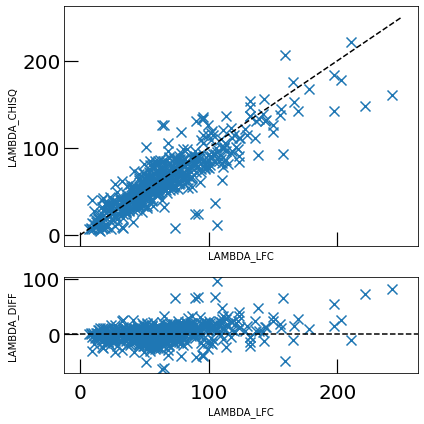

In [116]:
#Difference between Z_LAMBDA and Z_LAMBDA TARG
x = np.linspace(0,250,100)

plt.figure(tight_layout=True)
f, (a0, a1) = plt.subplots(2, 1, figsize=(6,6), gridspec_kw={'height_ratios': [2.5,1]}, tight_layout=True, sharex=True)
s = a0.scatter(match_top_df.LAMBDA_LFC, match_top_df.LAMBDA_CHISQ, s=100, marker='x')
a0.plot(x,x, linestyle='dashed', color='black')
a0.set_xlabel('LAMBDA_LFC'); a0.set_ylabel('LAMBDA_CHISQ')
#a0.set_xlim([0,1]); a0.set_ylim([0,1])

#Plotting the difference 
z_diff = match_top_df.LAMBDA_LFC - match_top_df.LAMBDA_CHISQ
a1.scatter(match_top_df.LAMBDA_LFC, z_diff, s=100, marker='x')
a1.set_xlabel('LAMBDA_LFC'); a1.set_ylabel('LAMBDA_DIFF')
#a1.set_xlim([0,1]); a1.set_ylim([-0.03,0.03])
a1.axhline(0, linestyle='dashed', color='black')
#plt.savefig('MCMF_SZ_RMfull_lambdaRM_vs_lambda_mcmf.png')

plt.show()

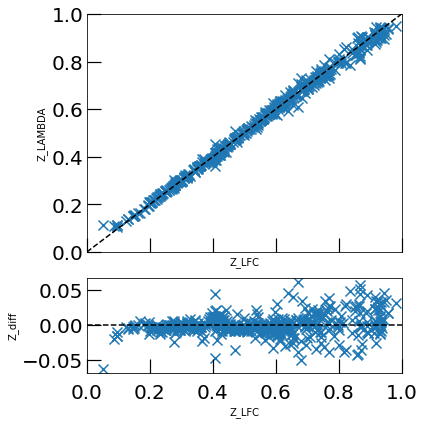

In [68]:
#Difference between Z_LAMBDA and Z_LAMBDA TARG
x = np.linspace(0,2,100)

f, (a0, a1) = plt.subplots(2, 1, figsize=(6,6), gridspec_kw={'height_ratios': [2.5,1]}, tight_layout=True, sharex=True)
s = a0.scatter(match_top_df.Z_SPT, match_top_df.Z_LAMBDA, s=100, marker='x')
a0.plot(x,x, linestyle='dashed', color='black')
a0.set_xlabel('Z_LFC'); a0.set_ylabel('Z_LAMBDA')
a0.set_xlim([0,1]); a0.set_ylim([0,1])

#Plotting the difference 
z_diff = match_top_df.Z_SPT - match_top_df.Z_LAMBDA
a1.scatter(match_top_df.Z_SPT, z_diff, s=100, marker='x')
a1.set_xlabel('Z_LFC'); a1.set_ylabel('Z_diff')
#a1.set_xlim([0,1]); a1.set_ylim([-0.03,0.03])
a1.axhline(0, linestyle='dashed', color='black')
#plt.savefig('RMY3_MCMF_SZ_topmatch_zlfc_vs_zlambda.png')

plt.show()

#### Test for multiple matches
For each top matched cluster determine if there are multiple good matches in RM. 

1. Compare Z_lfc with Z_RM. If they are about the same then they are good matches. 
2. If Z_lfc siginificantly different from Z_RM iterate through the top three peaks. If RM matches another peak then it's a multiple match.

Chances of finding multiple matches should be 1-2% 



In [69]:
z_diff_cut = 0.05
high_z_diff_df = match_top_df[np.abs(match_top_df.Delta_Z) > z_diff_cut]                         
print("For z diff lim of {:g}, ".format(z_diff_cut) + "number of clusters with high z separation is {:d}".format(len(high_z_diff_df))) 

For z diff lim of 0.05, number of clusters with high z separation is 5


In [70]:
high_z_diff_df.index

Int64Index([116, 299, 551, 662, 789], dtype='int64')

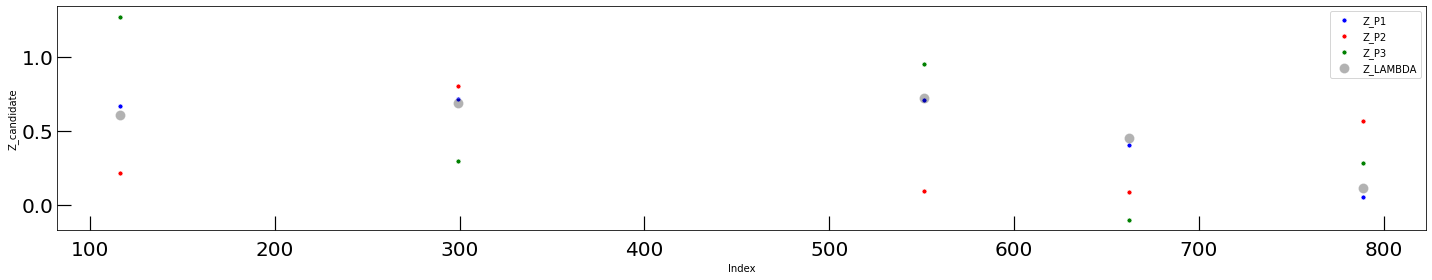

In [71]:
#For each one of these compare Z_P1, Z_P2 and Z_P3. Check if there is another candidate with a closer redshift. 
import seaborn as sns
plt.figure(figsize=(20,4), tight_layout=True)
ax =sns.lineplot(x=high_z_diff_df.index, y='Z_P1', data=high_z_diff_df,
             marker='o', linestyle='', markersize=5, color='blue', label='Z_P1')
sns.lineplot(x=high_z_diff_df.index, y='Z_P2', data=high_z_diff_df,
             marker='o', linestyle='', markersize=5, color='red', label='Z_P2')
sns.lineplot(x=high_z_diff_df.index, y='Z_P3', data=high_z_diff_df,
             marker='o', linestyle='', markersize=5, color='green', label='Z_P3')
sns.lineplot(x=high_z_diff_df.index, y='Z_LAMBDA', data=high_z_diff_df,
             marker='o', linestyle='', markersize=10, alpha =0.3, color='black', label='Z_LAMBDA')

ax.set(xlabel='Index', ylabel='Z_candidate')
plt.savefig('mcmf_z_candidates.png')
plt.show()

In [ ]:
spurious_mask = match_top_df.apply(lambda x: x['F_CONT_COMB'] > 0.1, axis=1)
num_spurious = len(match_top_df[spurious_mask])
print("Fraction of spurious matches ", num_spurious/len(match_top_df))

In [ ]:
match_top_df = match_top_df[spurious_mask]

In [ ]:
multiple_mask = match_top_df.apply(lambda x: (np.abs(x['F_CONT_P1']-x['F_CONT_P2'])< 0.05) | (np.abs(x['F_CONT_P2']-x['F_CONT_P3'])< 0.05) \
                                   | (np.abs(x['F_CONT_P1']-x['F_CONT_P3'])< 0.05), axis=1)
num_multiple = len(match_top_df[multiple_mask])
print("Fraction of mutiple matches ", num_multiple/len(match_top_df))

In [ ]:
## Test for multiple matches
match_top_df.apply(lambda x: x['F_CONT'] > 0.3, axis=1)

### Testing the properties with different aperture sizes. 

In [ ]:
'''
Creates a dataframe of matching properties with aperture and redshift separation iterated. 

Parameters:
matched_cl: a matched_clusters object
delta_d_lim: A 1D list of distance separation
delta_z_lim: A 1D list of redshift separation. 

Returns:
iterate_match_df: A dataframe containing columns ['d_lim', 'delta_z_lim', 'num_match', 'num_multiple']
'''

def run_match_iterate(matched_cl, delta_d_lim, delta_z_lim):
    
    iterate_match_df = pd.DataFrame(columns=['d_lim', 'delta_z_lim', 'num_match', 'num_multiple'])

    for i, d_cur in tqdm(enumerate(delta_d_lim)):
        for j, z_lim_cur in enumerate(delta_z_lim):

            matched_cl.run_match(['RA_SPT','DEC_SPT','xi', 'Z_SPT'], ['RA_REDM','DEC_REDM','LAMBDA_CHISQ', 'Z_REDM'], \
                    d_cur, delta_z_lim = z_lim_cur, aperture_type = 'distance', verbose=False)

            iterate_match_df = iterate_match_df.append({'d_lim': d_cur, 'delta_z_lim': z_lim_cur, \
                                     'num_match':matched_cl.get_num_match(), \
                                     'num_multiple':matched_cl.get_multiple_candidates()['num_multiple']}, ignore_index=True)
    return iterate_match_df
        
'''
Plots heatmap of number of matches and multiple matches as a function of redshift limit and distance separation limit. 
'''
def plot_match_iterate(iterate_match_df):
    sns.heatmap(iterate_match_df.pivot_table(index = 'd_lim',columns ='delta_z_lim',values ='num_match'), annot=True)
    plt.show()
    sns.heatmap(iterate_match_df.pivot_table(index = 'd_lim',columns ='delta_z_lim',values ='num_multiple'), annot=True)
    plt.show()
    return

In [ ]:
delta_d_lim = [500, 1000]
delta_z_lim = [0.01, 0.05]

iterate_match_df = run_match_iterate(matched_cl, delta_d_lim, delta_z_lim)

In [ ]:
plot_match_iterate(iterate_match_df)